In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import sequence_jacobian as sj
from winding_number import winding_number

# 1. Motivating example: Jacobians for Calvo pricing

In [2]:
beta = 0.98
theta = 0.75

In [3]:
T = 500
forward = (1-beta*theta)*(beta*theta)**np.arange(T)
Forward = np.triu(linalg.toeplitz(forward))

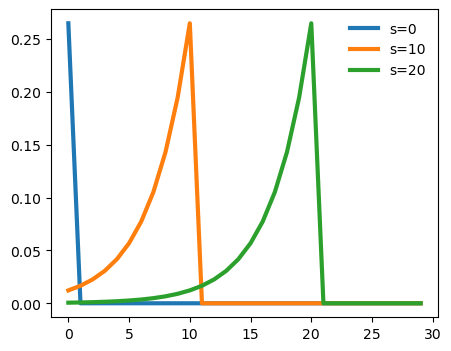

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(Forward[:30, [0, 10, 20]], linewidth=3)
plt.legend(['s=0', 's=10', 's=20'], frameon=False)
plt.savefig('figures/lecture8_fig1', transparent=True)

In [5]:
backward = (1-theta)*theta**np.arange(T)
Backward = np.tril(linalg.toeplitz(backward))

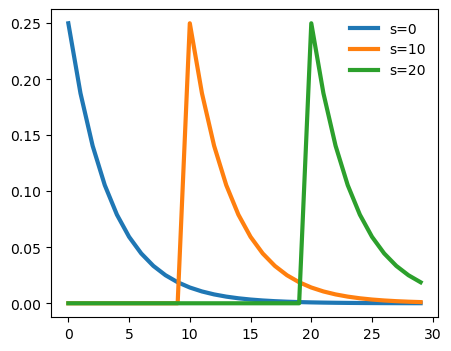

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(Backward[:30, [0, 10, 20]], linewidth=3)
plt.legend(['s=0', 's=10', 's=20'], frameon=False)
plt.savefig('figures/lecture8_fig2.pdf', transparent=True)

In [7]:
Psi = Backward @ Forward

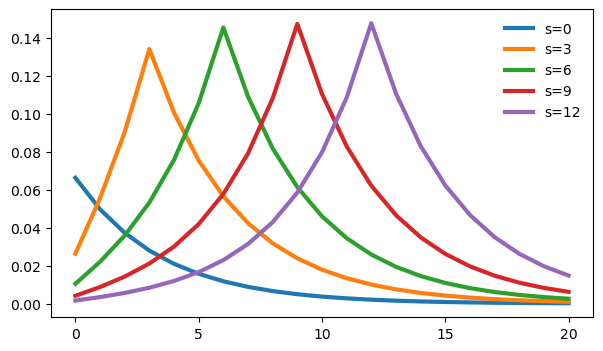

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(Psi[:21, [0, 3, 6, 9, 12]], linewidth=3)
plt.legend(['s=0', 's=3', 's=6', 's=9', 's=12'], frameon=False)
plt.xticks([0, 5, 10, 15, 20])
plt.savefig('figures/lecture8_fig3.pdf', transparent=True)

# 2. Heterogeneous-agent example: basic
For simplicity, we'll just use the default calibration built into SSJ.

In [9]:
calib = sj.hetblocks.hh_sim.example_calibration()
hh = sj.hetblocks.hh_sim.hh_extended
ss = hh.steady_state(calib)

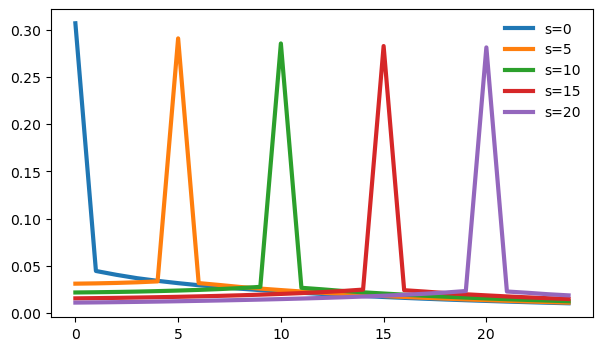

In [ ]:
M = hh.jacobian(ss, inputs=['w'], outputs=['C'], T=500)['C', 'w']
plt.figure(figsize=(7, 4))
plt.plot(M[:25, [0, 5, 10, 15, 20]], linewidth=3)
plt.legend(['s=0', 's=5', 's=10', 's=15', 's=20'], frameon=False)
plt.xticks([0, 5, 10, 15, 20])
plt.savefig('figures/lecture8_fig4.pdf', transparent=True)

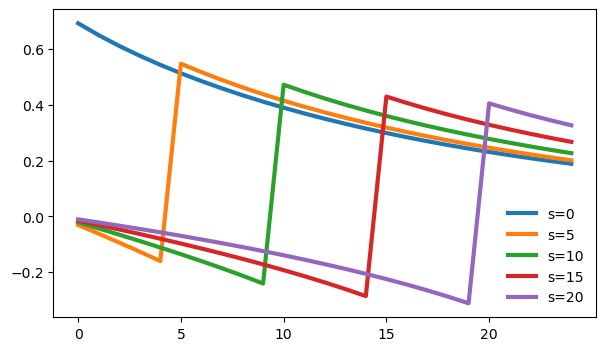

In [ ]:
A = hh.jacobian(ss, inputs=['w'], outputs=['A'], T=500)['A', 'w']
plt.figure(figsize=(7, 4))
plt.plot(A[:25, [0, 5, 10, 15, 20]], linewidth=3)
plt.legend(['s=0', 's=5', 's=10', 's=15', 's=20'], frameon=False)
plt.xticks([0, 5, 10, 15, 20])
plt.savefig('figures/lecture8_fig5.pdf', transparent=True)

# 3. Heterogeneous-agent example: varying countercyclical risk parameter

Quickly modify model to allow for cyclicality of income risk / inequality, given by $\zeta$, like we saw in Adrien's second lecture:

In [12]:
def income_cyclical(Y, e_grid, e_pdf, zeta):
    y = Y * e_grid ** (1 + zeta * np.log(Y)) / np.vdot(e_grid ** (1 + zeta * np.log(Y)), e_pdf)
    return y

def make_grids_pdf(rho_e, sd_e, n_e, min_a, max_a, n_a):
    # need new make_grids that exports pdf
    e_grid, e_pdf, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, e_pdf, Pi, a_grid

hh = sj.hetblocks.hh_sim.hh.add_hetinputs([income_cyclical, make_grids_pdf])

Steady state with default calibration, assuming acyclical risk $\zeta=0$ to start:

In [13]:
calib = sj.hetblocks.hh_sim.example_calibration()
calib['zeta'], calib['Y'] = 0, 1
ss = hh.steady_state(calib)

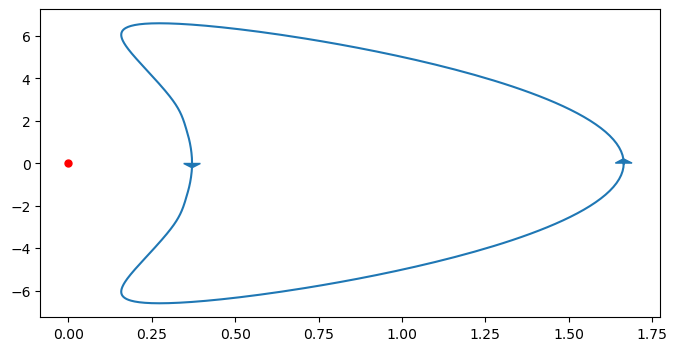

In [ ]:
T = 1000
A = hh.jacobian(ss, inputs=['Y'], outputs=['A'], T=T)['A', 'Y']

# take final column and then final (reversed) row to get best estimate of Toeplitz
a = np.concatenate((A[:, -1], A[-1, :-1][::-1]))

# what is winding number in our default case?
plt.figure(figsize=(8, 4))
winding_number(a, plot=True)
plt.savefig('figures/lecture8_fig6.pdf', transparent=True)

Now let's go to countercyclical case:

In [15]:
ss_alt = ss.copy()
ss_alt['zeta'] = -0.4
A_alt = hh.jacobian(ss_alt, inputs=['Y'], outputs=['A'], T=T)['A', 'Y']
a_alt = np.concatenate((A_alt[:, -1], A_alt[-1, :-1][::-1]))

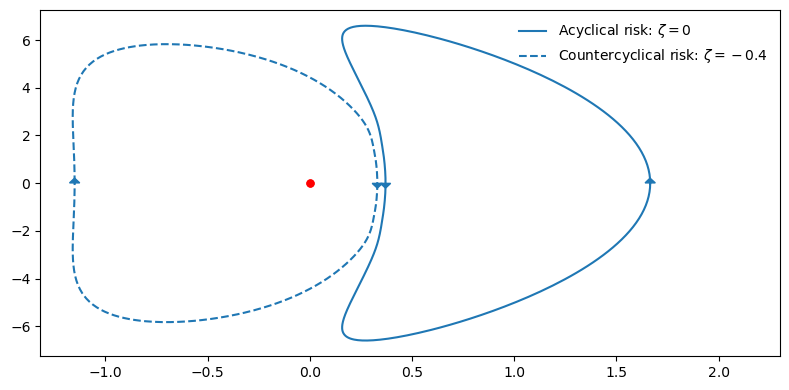

In [ ]:
plt.figure(figsize=(8, 4))
(winding_number(a, plot=True, label='Acyclical risk: $\zeta=0$'),
winding_number(a_alt, plot=True, linestyle='--', label='Countercyclical risk: $\zeta=-0.4$'))
plt.xlim(None, 2.3)
plt.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig('figures/lecture8_fig7.pdf', transparent=True)

What does the multiplicity look like in the indeterminate case? Can use the singular value decomposition to find the vector that is nearly in the null-space of `A_alt`, which corresponds to a self-fulfilling fluctuation in output:

In [17]:
U, s, Vh = np.linalg.svd(A_alt)
s[-5:]

array([0.33048511, 0.33048226, 0.33048023, 0.33047901, 0.00398561])

5.734277909194563e-05


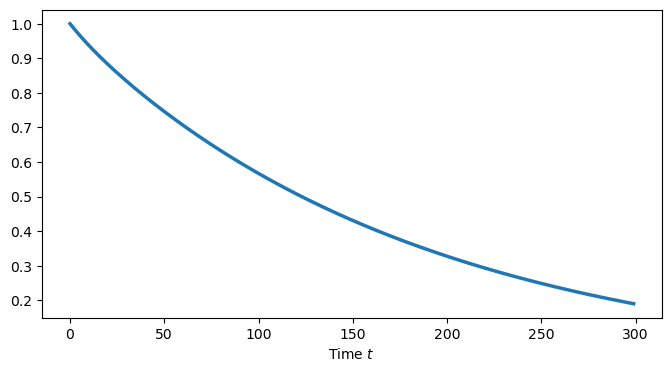

In [ ]:
mult = Vh[-1, :300]
mult /= mult[0] # normalize so that output starts at +1
print(np.max(np.abs((A_alt[:300, :300] @ mult))[:150])) # test close to zero
plt.figure(figsize=(8, 4))
plt.plot(mult, linewidth=2.5)
plt.xlabel('Time $t$')
#plt.title('Self-fulfilling boom in output')
plt.savefig('figures/lecture8_fig8.pdf', transparent=True)

Now let's iterate over various levels of $\zeta$ and plot the winding number in each case, to see when the model is determinate or not:

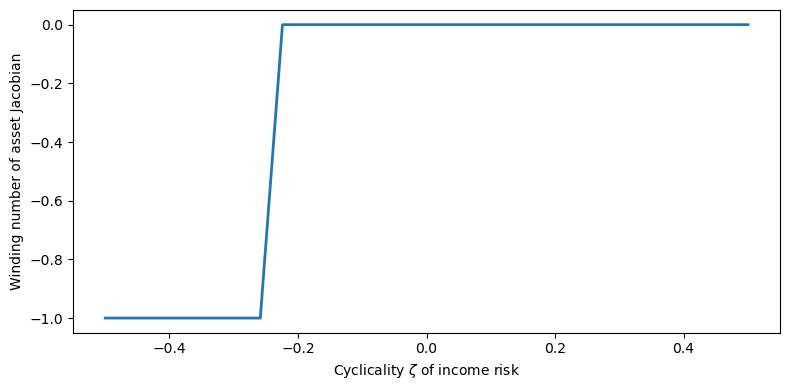

In [ ]:
zetas = np.linspace(-0.5, 0.5, 30)
wn = np.empty_like(zetas)
for i, zeta in enumerate(zetas):
    ss_alt['zeta'] = zeta
    A_alt = hh.jacobian(ss_alt, inputs=['Y'], outputs=['A'], T=T)['A', 'Y']
    a_alt = np.concatenate((A_alt[:, -1], A_alt[-1, :-1][::-1]))
    wn[i] = winding_number(a_alt)
plt.figure(figsize=(8, 4))
plt.plot(zetas, wn, lw=2)
plt.xlabel('Cyclicality $\zeta$ of income risk')
plt.ylabel('Winding number of asset Jacobian')
plt.tight_layout()
plt.savefig('figures/lecture8_fig9.pdf', transparent=True);

# 4. How low-rank is correction for $\mathbf{A}$?

In [20]:
T_A = linalg.toeplitz(a[T-1:], a[:T][::-1]) # Toeplitz part of A
E_A = A - T_A # correction

In [21]:
U, s, Vh = np.linalg.svd(E_A)
s[:20]

array([2.96425049e+00, 9.40962572e-02, 1.51029085e-02, 4.14270476e-03,
       1.55852286e-03, 6.25932175e-04, 2.83117149e-04, 1.36566154e-04,
       6.99214237e-05, 3.79063185e-05, 2.18091911e-05, 1.29835763e-05,
       8.11628988e-06, 5.28896276e-06, 3.63116357e-06, 2.54590216e-06,
       1.84158103e-06, 1.32967585e-06, 9.80162689e-07, 7.18425673e-07])

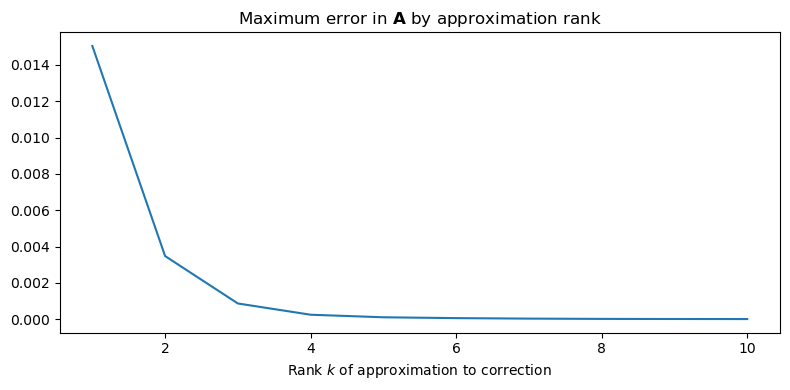

In [ ]:
errs = np.empty(10)
for rk in range(1, 11):
    errs[rk-1] = np.max(np.abs(E_A - U[:, :rk] @ np.diag(s[:rk]) @ Vh[:rk, :]))
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), errs)
plt.xlabel('Rank $k$ of approximation to correction')
plt.title('Maximum error in $\mathbf{A}$ by approximation rank')
plt.tight_layout()
plt.savefig('figures/lecture8_fig10.pdf', transparent=True)

In [ ]:
# same thing with a log 10 plot
plt.figure(figsize=(8, 4))
plt.semilogy(range(1, 11), errs)
plt.xlabel('Rank $k$ of approximation to correction')
plt.title('Maximum error in $\mathbf{A}$ by approximation rank')
plt.tight_layout()
plt.savefig('figures/lecture8_fig11.pdf', transparent=True)